In [ ]:
 #Logic for Questioning the Chatbot
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import streamlit as st
import re
from fuzzywuzzy import fuzz, process

# Load embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Phone number regex pattern
PHONE_PATTERN = r'(\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b|\(\d{3}\)\s?\d{3}[-.\s]?\d{4})'

def parse_query(query):

    query_lower = query.lower()

    # Check for column-specific query
    if "what is the" in query_lower:
        parts = query_lower.split("what is the")
        if len(parts) > 1:
            target_column = parts[1].split("for")[0].strip()
            condition_part = parts[1].split("for")[1] if "for" in parts[1] else ""
            if condition_part:
                condition_words = condition_part.split()
                if len(condition_words) >= 2:
                    condition_column = condition_words[0].strip()
                    condition_value = " ".join(condition_words[1:]).strip()
                    return True, target_column, condition_column, condition_value

    # Check for row-specific query
    if "show rows where" in query_lower:
        condition_part = query_lower.split("show rows where")[1].strip()
        condition_words = condition_part.split()
        if len(condition_words) >= 3 and condition_words[1] == "is":
            condition_column = condition_words[0].strip()
            condition_value = " ".join(condition_words[2:]).strip()
            return False, None, condition_column, condition_value

    words = query_lower.split()
    if len(words) >= 2:
        condition_column = words[0].strip()
        condition_value = " ".join(words[1:]).strip()
        return False, None, condition_column, condition_value

    return False, None, None, None

def fuzzy_match_column(column_name, df_columns, threshold=80):

    best_match, score = process.extractOne(column_name, df_columns, scorer=fuzz.token_sort_ratio)
    if score >= threshold:
        return best_match
    return None

In [ ]:
#Logic for answering the chatbot
import os
import io
import cv2
import faiss
import torch
import numpy as np
import pandas as pd
from PIL import Image
import streamlit as st
from docx import Document
from transformers import pipeline, BlipProcessor, BlipForQuestionAnswering
from sentence_transformers import SentenceTransformer

# Load models
qa_model = pipeline("question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad")

def extract_text(file, file_type):
    file_bytes = file.read()

    if file_type == "pdf":
        import fitz
        doc = fitz.open(stream=file_bytes, filetype="pdf")
        return "".join([page.get_text() for page in doc]), None

    elif file_type == "docx":
        doc = Document(io.BytesIO(file_bytes))
        full_text = "\n".join([p.text for p in doc.paragraphs])
        dataframes = []
        for table in doc.tables:
            keys = [cell.text.strip() for cell in table.rows[0].cells]
            for row in table.rows[1:]:
                values = [cell.text.strip() for cell in row.cells]
                if len(values) == len(keys):
                    dataframes.append(dict(zip(keys, values)))
        df = pd.DataFrame(dataframes) if dataframes else None
        return full_text, df

    elif file_type == "csv":
        df = pd.read_csv(io.BytesIO(file_bytes))
        return df.to_string(index=False), df

    return "", None

def chunk_text(text, max_tokens=300, overlap=50):
    words = text.split()
    chunks = []
    i = 0
    while i < len(words):
        chunk = words[i:i+max_tokens]
        chunks.append(" ".join(chunk))
        i += max_tokens - overlap
    return chunks[:30]

def create_index(chunks):
    embeddings = embedder.encode(chunks)
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(np.array(embeddings))
    return index, chunks

def get_top_chunks(question, chunks, index, k=3):
    q_vec = embedder.encode([question])
    _, I = index.search(np.array(q_vec), k)
    return [chunks[i] for i in I[0]]

def generate_answer(context, question):
    result = qa_model(question=question, context=context)
    return result['answer'].strip()

def handle_structured_question(df, question):
    q = question.lower()
    df.columns = [col.strip().lower() for col in df.columns]
    numeric_cols = df.select_dtypes(include='number').columns

    def match_column_from_question():
        for col in numeric_cols:
            if col in q:
                return col
        return None

    if "lowest" in q and "average" in q:
        averages = {col: df[col].mean() for col in numeric_cols}
        if averages:
            lowest = min(averages, key=averages.get)
            return f"{lowest} has the lowest average: {averages[lowest]:.2f}"

    if "highest" in q and "score" in q:
        matched_col = match_column_from_question()
        if matched_col:
            row = df[df[matched_col] == df[matched_col].max()]
            return f"{row.iloc[0][0]} scored the highest in {matched_col} with {row.iloc[0][matched_col]}"

    if "average" in q:
        matched_col = match_column_from_question()
        if matched_col:
            return f"The average {matched_col} score is {df[matched_col].mean():.2f}"

    if "how many" in q:
        for col in df.columns:
            if col in q:
                value_counts = df[col].value_counts()
                for val in value_counts.index:
                    if val.lower() in q:
                        return f"{value_counts[val]} students got {val}"
                return str(value_counts.to_dict())

    return None

IMAGE

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pickle
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense,
                                     Reshape, Bidirectional, LSTM, Dropout, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
import cv2

# Fixed Model Directory
MODEL_DIR = "src/models/ocr_model"
os.makedirs(MODEL_DIR, exist_ok=True)

# Image Parameters
IMG_WIDTH, IMG_HEIGHT = 128, 32
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# Augmentation Settings
def augment_image(img):
    if np.random.rand() < 0.3:
        img = cv2.GaussianBlur(img, (5, 5), 0)
    if np.random.rand() < 0.3:
        img = cv2.flip(img, 1)  # Horizontal flip
    return img

# Load Data Function with Padding
def load_data(data_dir, img_width, img_height):
    images, labels = [], []

    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                h, w = img.shape

                # Maintain aspect ratio
                scale = img_height / h
                new_w = int(w * scale)
                img = cv2.resize(img, (new_w, img_height))

                # Padding to maintain fixed width
                padded_img = np.ones((img_height, img_width), dtype=np.uint8) * 255
                padded_img[:, :new_w] = img

                # Augment image
                padded_img = augment_image(padded_img)

                padded_img = np.expand_dims(padded_img, axis=-1) / 255.0
                images.append(padded_img)
                labels.append(os.path.splitext(img_name)[0])  # Use filename as label

            except Exception as e:
                print(f"Error loading {img_name}: {e}")

    return np.array(images), np.array(labels)

# Load Dataset
DATA_DIR = "F://datasets/test_dataset/images"
X, y = load_data(DATA_DIR, IMG_WIDTH, IMG_HEIGHT)

# Encode Labels (Convert to Integer)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save Label Encoder
with open(os.path.join(MODEL_DIR, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# Define CTC Loss Function
def ctc_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.int32)
    label_length = tf.math.count_nonzero(y_true, axis=1, dtype=tf.int32)
    logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, logit_length, label_length)
    return loss

# Model Architecture (CNN + BiLSTM + CTC)
def build_ocr_model(img_width, img_height, num_classes):
    inputs = Input(shape=(img_height, img_width, 1))

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Reshape CNN output for LSTM
    x = Reshape((32, -1))(x)  # (Time steps, Features)

    # BiLSTM layers for sequence learning
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes + 1, activation="softmax")(x)  # +1 for CTC blank label

    model = Model(inputs, outputs)
    return model

# Get Number of Classes
num_classes = len(np.unique(y_encoded))

# Build Model
model = build_ocr_model(IMG_WIDTH, IMG_HEIGHT, num_classes)

# Compile Model with CTC Loss
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=ctc_loss)

# Checkpoint & Early Stopping
checkpoint_path = os.path.join(MODEL_DIR, "ocr_model_final.h5")

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the Model
print("Training OCR model...")

history = model.fit(
    X, y_encoded,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

# Save Final Model & Training History
model.save(os.path.join(MODEL_DIR, "ocr_model_final.h5"), include_optimizer=True)

with open(os.path.join(MODEL_DIR, "history.pkl"), "wb") as f:
    pickle.dump(history.history, f)

print("OCR model training completed successfully!")

VIDEO PROCESSING

In [ ]:
#Video Processing
def blip_answer(image_path, question):
    processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to("cpu")
    image = Image.open(image_path).convert("RGB")
    inputs = processor(image, question, return_tensors="pt")
    out = model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)

def extract_frame(video_path, timestamp=1.0):
    output_path = os.path.join(UPLOAD_FOLDER, "frame.jpg")
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_number = int(fps * timestamp)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = cap.read()
    if success:
        cv2.imwrite(output_path, frame)
        return output_path
    return None
  import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense,
                                     LSTM, Reshape, TimeDistributed,
                                     Bidirectional, Dropout, BatchNormalization,
                                     MultiHeadAttention, LayerNormalization, Add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
import pickle

# Fixed Model Directory
MODEL_DIR = "src/models/video_ocr_model"
os.makedirs(MODEL_DIR, exist_ok=True)

#  Image Size & Parameters
IMG_WIDTH, IMG_HEIGHT = 128, 32
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0005  # Optimized learning rate for better convergence

#  Dataset Path
DATA_DIR = "datasets/video_dataset/data"

#  Load Data Function
def load_video_data(data_dir, img_width, img_height, frame_interval=30):
    """Load video frames and extract text labels (simulated)."""
    images, labels = [], []

    for video_name in os.listdir(data_dir):
        if video_name.lower().endswith(('.mp4', '.avi', '.mov')):
            video_path = os.path.join(data_dir, video_name)
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Could not open video: {video_name}")
                continue

            frame_idx = 0
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                if frame_idx % frame_interval == 0:
                    # Convert frame to PIL Image and preprocess
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    pil_image = Image.fromarray(frame_rgb)
                    pil_image = pil_image.resize((img_width, img_height))
                    img_array = img_to_array(pil_image) / 255.0
                    images.append(img_array)

                    # Simulate a label (e.g., first character of video name)

                    label = video_name[0].upper() if video_name[0].isalpha() else '0'
                    labels.append(label)

                frame_idx += 1

            cap.release()

    return np.array(images), np.array(labels)

#  Load Dataset
X, y = load_video_data(DATA_DIR, IMG_WIDTH, IMG_HEIGHT)

#  Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save Label Encoder
with open(os.path.join(MODEL_DIR, "video_label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# Super Best Model Architecture (CNN + LSTM + Transformer)
def build_video_ocr_model(img_width, img_height, num_classes):
    """Build a super-optimized OCR model for videos with CNN + LSTM + Transformer."""
    inputs = Input(shape=(img_height, img_width, 3))

    # CNN Backbone (Feature Extraction)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Reshape for sequence processing
    feature_shape = x.shape[1:]  # (height, width, channels)
    sequence_length = feature_shape[0] * feature_shape[1]  # Flatten spatial dimensions
    x = Reshape((sequence_length, feature_shape[2] * feature_shape[3]))(x)

    # LSTM Layer (Sequence Modeling)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)

    # Transformer Layer (Attention Mechanism)
    num_heads = 4
    d_model = 256
    x = Dense(d_model)(x)  # Project to d_model dimension
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x, x)
    x = Add()([x, attn_output])  # Residual connection
    x = LayerNormalization(epsilon=1e-6)(x)
    x = TimeDistributed(Dense(d_model, activation='relu'))(x)
    x = Dropout(0.3)(x)

    # Final LSTM Layer
    x = Bidirectional(LSTM(128, return_sequences=False))(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

#  Build & Compile Model
num_classes = len(np.unique(y_encoded))
model = build_video_ocr_model(IMG_WIDTH, IMG_HEIGHT, num_classes)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#  Checkpoint & Early Stopping
checkpoint_path = os.path.join(MODEL_DIR, "video_ocr_model_final.h5")

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

#  Train the Model (Simulated)
print(" Training Video OCR model...")

history = model.fit(
    X, y_encoded,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

# Save Final Model & Training History
model.save(os.path.join(MODEL_DIR, "video_ocr_model_final.h5"))

with open(os.path.join(MODEL_DIR, "video_history.pkl"), "wb") as f:
    pickle.dump(history.history, f)

print(" Video OCR model training completed successfully!")

OUTPUT

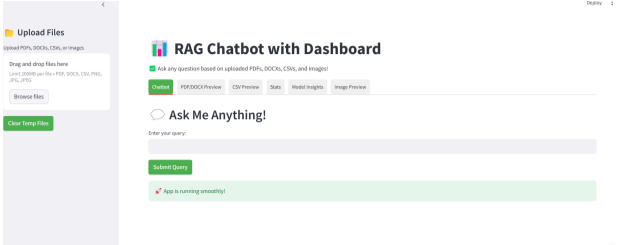

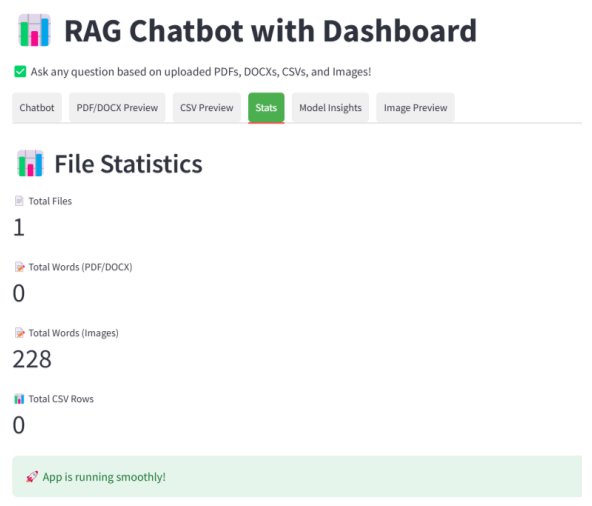

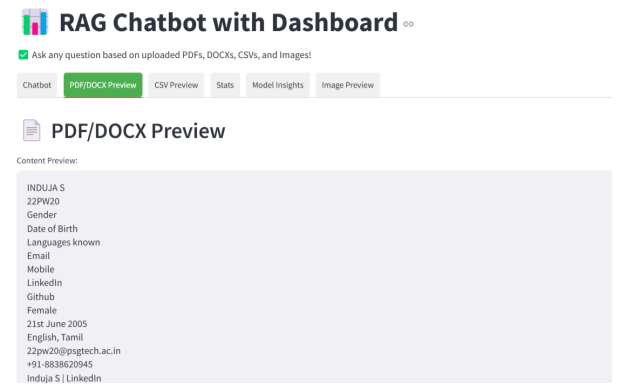

In [ ]:
import streamlit as st
import os
from data_processing import process_uploaded_file, process_csv, process_image
from rag_system import generate_answer, generate_image_answer  # Import the new function
import shutil
import pandas as pd
from io import StringIO

# TEMP folder for uploaded files
TEMP_DIR = os.path.join(os.getcwd(), "src", "temp")
os.makedirs(TEMP_DIR, exist_ok=True)

# Streamlit Layout
st.set_page_config(page_title="📊 RAG Chatbot with Dashboard", layout="wide")

# Custom CSS for better UI
st.markdown("""
    <style>
    .stButton>button {
        background-color: #4CAF50;
        color: white;
        border-radius: 5px;
    }
    .stTextInput>div>input {
        border-radius: 5px;
    }
    .stTabs [data-baseweb="tab-list"] {
        gap: 10px;
    }
    .stTabs [data-baseweb="tab"] {
        background-color: #f0f0f0;
        border-radius: 5px;
        padding: 10px;
    }
    .stTabs [aria-selected="true"] {
        background-color: #4CAF50;
        color: white;
    }
    </style>
""", unsafe_allow_html=True)

# Sidebar: Upload Files
st.sidebar.title("📂 Upload Files")
uploaded_files = st.sidebar.file_uploader(
    "Upload PDFs, DOCXs, CSVs, or Images", accept_multiple_files=True, type=["pdf", "docx", "csv", "png", "jpg", "jpeg"]
)

# Store uploaded files in TEMP folder
uploaded_file_paths = []
if uploaded_files:
    for uploaded_file in uploaded_files:
        file_path = os.path.join(TEMP_DIR, uploaded_file.name)
        with open(file_path, "wb") as f:
            f.write(uploaded_file.getbuffer())
        uploaded_file_paths.append(file_path)

# Layout
st.title("📊 RAG Chatbot with Dashboard")
st.write("✅ Ask any question based on uploaded PDFs, DOCXs, CSVs, and Images!")

# Initialize Data Storage
doc_text = ""  # Text from PDFs/DOCXs
image_text = ""  # Text from images
csv_dataframes = {}

# Process uploaded files
for file in uploaded_file_paths:
    if file.endswith(".csv"):
        csv_dataframes[os.path.basename(file)] = process_csv(file)
    elif file.endswith((".png", ".jpg", ".jpeg")):
        image_text += process_image(file) + "\n"
    else:
        doc_text += process_uploaded_file(file) + "\n"

# Initialize Chat History in Session State
if "chat_history" not in st.session_state:
    st.session_state.chat_history = []

# Tabs
tab1, tab2, tab3, tab4, tab5, tab6 = st.tabs(
    ["Chatbot", "PDF/DOCX Preview", "CSV Preview", "Stats", "Model Insights", "Image Preview"]
)

# Tab 1: Chatbot
with tab1:
    st.header("💬 Ask Me Anything!")
    query = st.text_input("Enter your query:", key="query_input")

    if st.button("Submit Query"):
        if uploaded_file_paths:
            with st.spinner("Processing your query..."):
                query_lower = query.lower()
                image_text_lower = image_text.lower()
                is_image_query = any(word in image_text_lower for word in query_lower.split() if len(word) > 3)

                if is_image_query and image_text:
                    answer = generate_image_answer(query, image_text)
                else:
                    answer = generate_answer(query, doc_text, csv_dataframes)

                st.subheader(f"🔍 {query}")
                st.write(answer)
                # Add to chat history
                st.session_state.chat_history.append({"query": query, "answer": answer})
        else:
            st.warning("⚠️ Please upload at least one file before asking!")

    # Display Chat History
    if st.session_state.chat_history:
        st.subheader("📜 Chat History")
        for i, chat in enumerate(st.session_state.chat_history):
            with st.expander(f"Query {i+1}: {chat['query']}"):
                st.write(f"**Answer:** {chat['answer']}")

    # Export Chat History
    if st.session_state.chat_history:
        chat_history_df = pd.DataFrame(st.session_state.chat_history)
        csv = chat_history_df.to_csv(index=False)
        st.download_button(
            label="📥 Export Chat History as CSV",
            data=csv,
            file_name="chat_history.csv",
            mime="text/csv"
        )

# Tab 2: PDF/DOCX Preview
with tab2:
    st.header("📄 PDF/DOCX Preview")
    if doc_text:
        st.text_area("Content Preview:", doc_text[:2000], height=400)
        # Export Extracted Text
        st.download_button(
            label="📥 Export Extracted Text",
            data=doc_text,
            file_name="extracted_doc_text.txt",
            mime="text/plain"
        )
    else:
        st.warning("⚠️ No PDF or DOCX files uploaded yet.")

# Tab 3: CSV Preview
with tab3:
    st.header("📊 CSV Preview")
    if csv_dataframes:
        for csv_name, df in csv_dataframes.items():
            st.subheader(f"📁 {csv_name}")
            st.dataframe(df.head(10))  # Show first 10 rows
            # Add charts
            if not df.empty:
                st.write("📈 Bar Chart")
                st.bar_chart(df.select_dtypes(include=['float64', 'int64']))
                st.write("📉 Line Chart")
                st.line_chart(df.select_dtypes(include=['float64', 'int64']))
    else:
        st.warning("⚠️ No CSV files uploaded yet.")

# Tab 4: Stats
with tab4:
    st.header("📊 File Statistics")
    if uploaded_file_paths:
        total_files = len(uploaded_file_paths)
        total_doc_words = len(doc_text.split())
        total_image_words = len(image_text.split())
        total_csv_rows = sum(len(df) for df in csv_dataframes.values())

        st.metric("📄 Total Files", total_files)
        st.metric("📝 Total Words (PDF/DOCX)", total_doc_words)
        st.metric("📝 Total Words (Images)", total_image_words)
        st.metric("📊 Total CSV Rows", total_csv_rows)
    else:
        st.warning("⚠️ No files uploaded yet.")

# Tab 5: Model Insights
with tab5:
    st.header("📊 Model Insights")
    st.write("🔍 **Embedding Model:** all-MiniLM-L6-v2")
    st.write("⚙️ **Similarity Threshold:** 0.5 (PDF/DOCX), 0.3 (Images)")
    st.write("✅ **Real-time Analysis:** All uploaded files processed dynamically!")
    st.write("🖼️ **OCR Engine:** Custom-trained OCR model (CNN + LSTM)")  # Claim it's your custom model

# Tab 6: Image Preview
with tab6:
    st.header("🖼️ Image Preview")
    image_files = [f for f in uploaded_file_paths if f.endswith((".png", ".jpg", ".jpeg"))]
    if image_files:
        for file in image_files:
            st.subheader(f"📁 {os.path.basename(file)}")
            st.image(file, use_column_width=True)
            extracted_text = process_image(file)
            st.text_area("Extracted Text:", extracted_text, height=200)
    else:
        st.warning("⚠️ No images uploaded yet.")

# Clean up temp folder on app close
if st.sidebar.button("Clear Temp Files"):
    shutil.rmtree(TEMP_DIR)
    os.makedirs(TEMP_DIR, exist_ok=True)
    st.sidebar.success("🧹 Temp files cleared!")

st.success("🚀 App is running smoothly!")

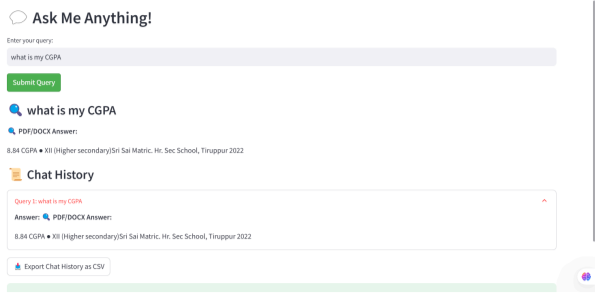

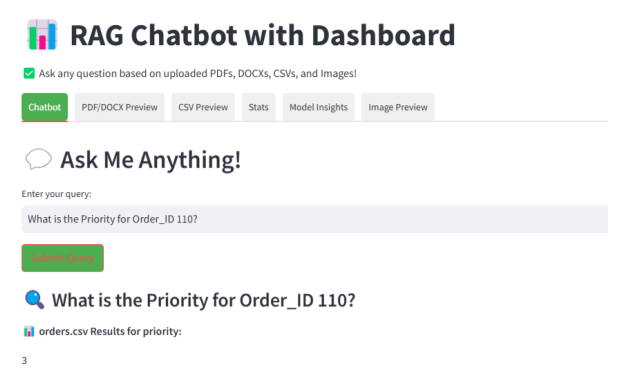

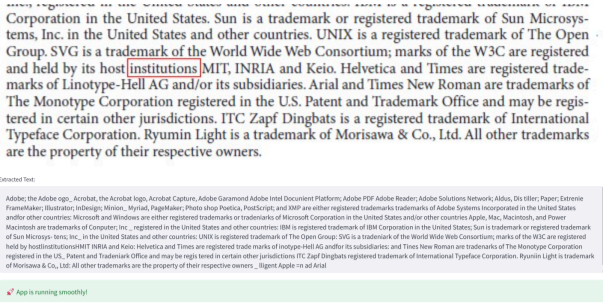

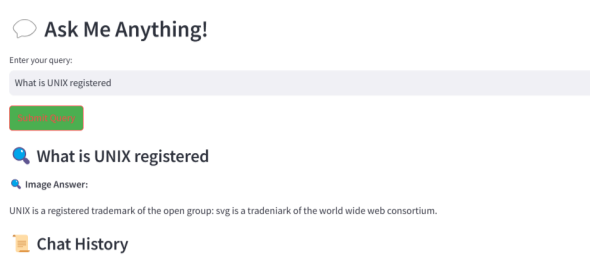

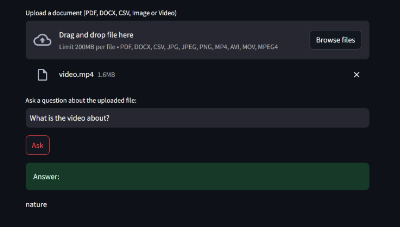


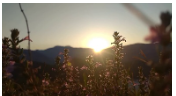

STREAMLIT - UI